In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Datasets/OCT2017_dataset.zip

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
target_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/OCT2017/train',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '/content/OCT2017/val',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


# ResNet50

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Input,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import VGG19

## feature extracture

In [ ]:

feature_extractor = ResNet50(weights='imagenet',
                          input_shape=(224, 224, 3),
                          include_top=False)
feature_extractor.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
for layer in feature_extractor.layers[0 :]:
    layer.trainable = False

feature_extractor.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

## Model with our classifier

In [ ]:
inp_layer = Input(shape = (224, 224, 3))
features = feature_extractor(inp_layer)

flat = Flatten()(features)
FC1 = Dense(units = 300, activation = 'relu')(flat)
FC2 = Dense(units = 200, activation = 'relu')(FC1)
output = Dense(units = 4, activation = 'softmax')(FC2)

model = Model(inputs = inp_layer, outputs = output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 300)               30105900  
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 4)                 804       
                                                                 
Total params: 53,754,616
Trainable params: 30,166,904
Non-tra

In [ ]:
checkpoint_path = "/content/callbacks"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 verbose=1)


In [ ]:
opt = Adam(learning_rate = 0.0001)
model.compile(optimizer = opt, loss=categorical_crossentropy, metrics = 'acc')

**train model**

In [ ]:
results_ResNet50 = model.fit(train_generator,
                    epochs = 10,
                    validation_data=validation_generator
                    , callbacks=[cp_callback])

Epoch 1/10
5218/5218 [==============================] - ETA: 0s - loss: 0.9502 - acc: 0.6430
Epoch 1: saving model to /content/callbacks
INFO:tensorflow:Assets written to: /content/callbacks/assets
5218/5218 [==============================] - 532s 99ms/step - loss: 0.9502 - acc: 0.6430 - val_loss: 1.0696 - val_acc: 0.5000
Epoch 2/10
5218/5218 [==============================] - ETA: 0s - loss: 0.8156 - acc: 0.6913
Epoch 2: saving model to /content/callbacks
INFO:tensorflow:Assets written to: /content/callbacks/assets
5218/5218 [==============================] - 517s 99ms/step - loss: 0.8156 - acc: 0.6913 - val_loss: 0.9425 - val_acc: 0.5312
Epoch 3/10
5218/5218 [==============================] - ETA: 0s - loss: 0.7556 - acc: 0.7126
Epoch 3: saving model to /content/callbacks
INFO:tensorflow:Assets written to: /content/callbacks/assets
5218/5218 [==============================] - 551s 106ms/step - loss: 0.7556 - acc: 0.7126 - val_loss: 0.8680 - val_acc: 0.5938
Epoch 4/10
5218/5218 [=====

## results of train and validation

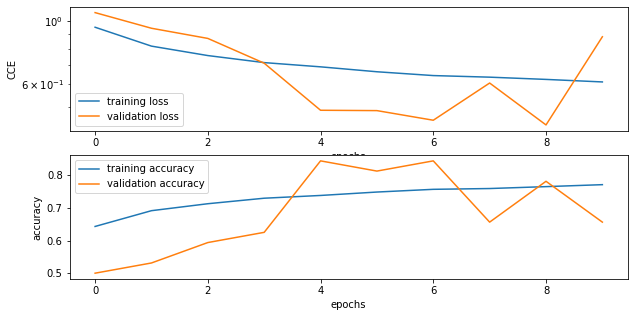

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss = results_ResNet50.history['loss']
val_loss = results_ResNet50.history['val_loss']
train_acc = results_ResNet50.history['acc']
val_acc = results_ResNet50.history['val_acc']

plt.subplots(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('CCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

## test prediction canfusion matrix and classification reports

In [ ]:
test_generator = test_datagen.flow_from_directory(
        '/content/OCT2017/test',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [ ]:
y_pred_test_Res = model.predict(test_generator)
y_pred_test_Res

array([[9.86371219e-01, 3.35196208e-04, 1.31343370e-02, 1.59137955e-04],
       [8.67646277e-01, 1.63769647e-02, 7.59816468e-02, 3.99951898e-02],
       [9.94036436e-01, 3.59230558e-03, 2.35057832e-03, 2.07006196e-05],
       ...,
       [1.16272504e-03, 1.00283809e-02, 5.51439188e-02, 9.33664978e-01],
       [9.76854041e-02, 9.86093655e-02, 1.11915655e-01, 6.91789567e-01],
       [2.83223152e-01, 6.38096482e-02, 3.13900024e-01, 3.39067191e-01]],
      dtype=float32)

In [ ]:
y_pred_test_Res=np.argmax(y_pred_test_Res,axis=1)
y_pred_test_Res

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 3, 3, 1, 3, 0, 0, 0, 0, 3, 3, 0, 3, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 2, 0, 0, 1, 0, 1, 0, 3, 0, 3, 0, 0, 0,

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_generator.classes, y_pred_test_Res))

[[242   0   0   0]
 [157  28  15  42]
 [135   0  98   9]
 [  2   0   5 235]]


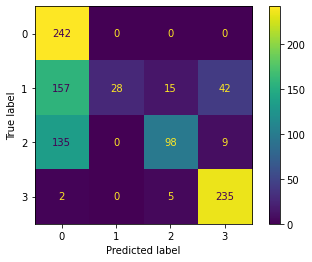

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_generator.classes, y_pred_test_Res)

In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = results_ResNet50.history
# Save it under the form of a json file
json.dump(history_dict, open('/content/drive/MyDrive/ResNet50.json', 'w'))

In [ ]:
from sklearn.metrics import classification_report
cls_report = classification_report(test_generator.classes,y_pred_test_Res)

print(cls_report)

              precision    recall  f1-score   support

           0       0.45      1.00      0.62       242
           1       1.00      0.12      0.21       242
           2       0.83      0.40      0.54       242
           3       0.82      0.97      0.89       242

    accuracy                           0.62       968
   macro avg       0.78      0.62      0.57       968
weighted avg       0.78      0.62      0.57       968



## Inception3

In [ ]:
from tensorflow.keras.applications.inception_v3  import InceptionV3
from tensorflow.keras.applications.inception_v3  import preprocess_input
from tensorflow.keras.layers import Input
import numpy as np

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Input,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
target_size = (299, 299)

train_datagen2 = ImageDataGenerator(rescale=1./255)
val_datagen2 = ImageDataGenerator(rescale=1./255)

train_generator2 = train_datagen2.flow_from_directory(
        '/content/OCT2017/train',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator2 = val_datagen2.flow_from_directory(
        '/content/OCT2017/val',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [ ]:
feature_extractor_Incept= InceptionV3(weights='imagenet',
                          input_shape=(299, 299, 3),
                          include_top=False)
feature_extractor_Incept.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
for layer in feature_extractor_Incept.layers[0 :]:
    layer.trainable = False

feature_extractor_Incept.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
inp_layer = Input(shape = (299, 299, 3))
features2 = feature_extractor_Incept(inp_layer)

flat = Flatten()(features2)
FC1 = Dense(units = 300, activation = 'relu')(flat)
FC2 = Dense(units = 200, activation = 'relu')(FC1)
output = Dense(units = 4, activation = 'softmax')(FC2)

model2 = Model(inputs = inp_layer, outputs = output)

model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 300)               39321900  
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 4)                 804       
                                                                 
Total params: 61,185,688
Trainable params: 39,382,904
Non-tra

In [ ]:
opt = Adam(learning_rate = 0.0001)
model2.compile(optimizer = opt, loss=categorical_crossentropy, metrics = 'acc')

In [ ]:
results_InceptionV3 = model2.fit(train_generator2,
                    epochs = 10,
                    validation_data=validation_generator2)

Epoch 1/10
5218/5218 [==============================] - 551s 103ms/step - loss: 0.4027 - acc: 0.8585 - val_loss: 0.1811 - val_acc: 0.9062
Epoch 2/10
5218/5218 [==============================] - 508s 97ms/step - loss: 0.2570 - acc: 0.9081 - val_loss: 0.1405 - val_acc: 0.9375
Epoch 3/10
5218/5218 [==============================] - 484s 93ms/step - loss: 0.1948 - acc: 0.9313 - val_loss: 0.1652 - val_acc: 0.9062
Epoch 4/10
5218/5218 [==============================] - 479s 92ms/step - loss: 0.1541 - acc: 0.9442 - val_loss: 0.1042 - val_acc: 0.9375
Epoch 5/10
5218/5218 [==============================] - 473s 91ms/step - loss: 0.1200 - acc: 0.9569 - val_loss: 0.0547 - val_acc: 0.9688
Epoch 6/10
5218/5218 [==============================] - 461s 88ms/step - loss: 0.0966 - acc: 0.9648 - val_loss: 0.0917 - val_acc: 0.9375
Epoch 7/10
5218/5218 [==============================] - 458s 88ms/step - loss: 0.0798 - acc: 0.9702 - val_loss: 0.0348 - val_acc: 1.0000
Epoch 8/10
5218/5218 [==================

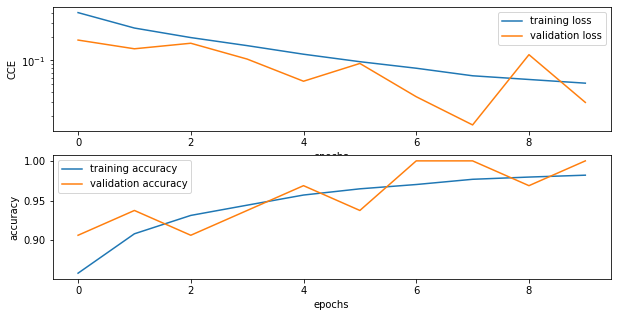

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss = results_InceptionV3.history['loss']
val_loss = results_InceptionV3.history['val_loss']
train_acc = results_InceptionV3.history['acc']
val_acc = results_InceptionV3.history['val_acc']

plt.subplots(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('CCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        '/content/OCT2017/test',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [ ]:
y_pred_test_Incept = model2.predict(test_generator)
y_pred_test_Incept

array([[9.9900144e-01, 5.5945822e-04, 4.3909406e-04, 8.3425343e-11],
       [9.9966002e-01, 2.1613688e-04, 1.2387456e-04, 9.9105002e-13],
       [9.9940479e-01, 5.7448645e-04, 2.0693231e-05, 6.7994926e-13],
       ...,
       [2.2808183e-06, 9.0191554e-07, 7.6608080e-04, 9.9923074e-01],
       [2.8201720e-11, 1.0026428e-07, 8.2272554e-06, 9.9999166e-01],
       [8.6811846e-13, 7.8464337e-09, 6.6993118e-07, 9.9999928e-01]],
      dtype=float32)

In [ ]:
y_pred_test_Incept=np.argmax(y_pred_test_Incept,axis=1)
y_pred_test_Incept

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_generator.classes, y_pred_test_Incept))

[[242   0   0   0]
 [  7 225   5   5]
 [  0   0 242   0]
 [  0   0   0 242]]


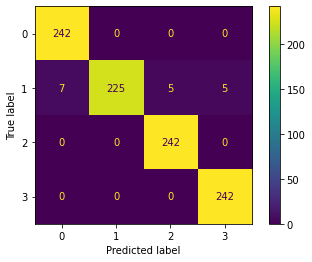

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_generator.classes, y_pred_test_Incept)

In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = results_InceptionV3.history
# Save it under the form of a json file
json.dump(history_dict, open('/content/drive/MyDrive/InceptionV3.json', 'w'))

In [ ]:
from sklearn.metrics import classification_report
cls_report = classification_report(test_generator.classes, y_pred_test_Incept)

print(cls_report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       242
           1       1.00      0.93      0.96       242
           2       0.98      1.00      0.99       242
           3       0.98      1.00      0.99       242

    accuracy                           0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968

